# Deep Learning Models  

This notebook contains the Deep Learning models we will use.

Here we are using two models:
1. LSTM
2. CNN1d

Importing relevant libraries

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

2025-02-20 12:21:48.415438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 12:21:48.421124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 12:21:48.427936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 12:21:48.430000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 12:21:48.435429: I tensorflow/core/platform/cpu_feature_guar

Defining training parameters.

In [5]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
PATIENCE = 50

#### Data Loading and Directory Setup

Loads training and test data for multiple stocks. The data is read from CSV files located in the specified `data_dir`, and the individual stock datasets are concatenated into unified training (`train_df`) and testing (`test_df`) DataFrames.

The models will be saved in the directory specified by `save_dir`.


In [6]:
# Define directories for data and model saving
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
save_dir = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models"
save_dir_lstm=f"{save_dir}/lstm"
save_dir_cnn=f"{save_dir}/cnn"

stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA'] 

# Initialize lists to store training and test DataFrames
train_dfs = []
test_dfs = []

# Load training and testing data for each stock
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    train_stock_df = pd.read_csv(f"{stock_dir}/treino.csv", index_col=0)
    test_stock_df = pd.read_csv(f"{stock_dir}/teste.csv", index_col=0)
    
    # Add a new column to indicate the stock symbol
    # train_stock_df['Stock'] = stock
    # test_stock_df['Stock'] = stock

    # Append DataFrames to respective lists
    train_dfs.append(train_stock_df)
    test_dfs.append(test_stock_df)

# Concatenate all training and testing DataFrames
train_df = pd.concat(train_dfs, ignore_index=False)
test_df = pd.concat(test_dfs, ignore_index=False)

# Apply one-hot encoding
# encoder = OneHotEncoder(sparse_output=False)  
# stock_encoded = encoder.fit_transform(train_df[['Stock']])

# # Convert the encoded array to a DataFrame with proper column names
# stock_encoded_df = pd.DataFrame(stock_encoded, 
#                                 columns=encoder.get_feature_names_out(['Stock']),
#                                 index=train_df.index)
                
# # Concatenate the one-hot encoded columns with the original DataFrame
# train_df = pd.concat([train_df, stock_encoded_df], axis=1)

# # Drop the original 'Stock' column as it's now encoded
# train_df.drop(columns=['Stock'], inplace=True)

# # Apply the same transformation to the test set
# stock_encoded_test = encoder.transform(test_df[['Stock']])
# stock_encoded_test_df = pd.DataFrame(stock_encoded_test, 
#                                      columns=encoder.get_feature_names_out(['Stock']),
#                                      index=test_df.index)

# test_df = pd.concat([test_df, stock_encoded_test_df], axis=1)
# test_df.drop(columns=['Stock'], inplace=True)

# Now, train_df and test_df have one-hot encoded stock columns.

In [7]:
train_df.head()

,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1,2000-01-24,1.062769,1.071645,-1,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
2,2000-01-26,1.087668,1.073247,-1,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
3,2000-01-27,1.064080,1.072330,-1,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
4,2000-01-28,1.036561,1.068753,-1,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
5,2000-01-31,1.035250,1.065403,-1,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


Label adjustment.

In [8]:
# Replace -1 with 0 in the fourth column (label column) for train_df and test_df
train_df.iloc[:, 3] = train_df.iloc[:, 3].replace(-1, 0)
test_df.iloc[:, 3] = test_df.iloc[:, 3].replace(-1, 0)

# Apply the same transformation to each individual DataFrame in test_dfs
for df in test_dfs:
    df.iloc[:, 3] = df.iloc[:, 3].replace(-1, 0)


Feature reshaping for model input.

In [9]:
# Extract features and labels
train_features = train_df.iloc[:, 4:].values  # Shape: (n_samples, total_features)
labels = train_df.iloc[:, 3].values          # Shape: (n_samples,)

# Separate columns: Normalize all except the last 4
# features_to_normalize = train_features[:, :-4]  # All columns except the last 4
# features_unchanged = train_features[:, -4:]    # Last 4 columns remain unchanged

# Apply StandardScaler only to the selected columns
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)

# Concatenate normalized and unchanged features back together
# train_features = np.hstack((normalized_features, features_unchanged))

# Reshape the feature matrix to (samples, timesteps, features)
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))

In [10]:
train_features.shape

(19094, 15, 1)

Define history ploting method.

In [11]:
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model_cnn.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

Defines EarlyStopping and ModelCheckpoint callbacks and a method to save a model. 

In [12]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=PATIENCE,          # Stop training if val_loss doesn't improve for 10 epochs
    restore_best_weights=True,  # Restore the best model weights after stopping
    verbose=1
)

# Define ModelCheckpoint callback
def save_best_model(model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"best_{model_name}.keras")

    checkpoint = ModelCheckpoint(
        filepath=save_path,  # Saves model as "best_cnn.h5" or "best_lstm.h5"
        monitor="val_loss",   # Track validation loss
        save_best_only=True,  # Save only the best model
        verbose=1             # Print when a model is saved
    )
    return checkpoint

def save_last_model(model, model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"last_{model_name}_{model.name}.keras")

    # Save the model
    model.save(save_path)

    print(f"Last model saved to: {save_path}")

## Models

### LSTM  Model.

In [13]:
# Define the model
model_lstm = Sequential([
    Input(shape=(15, 1)),               # Explicit Input layer
    LSTM(64),                           # LSTM layer with 64 units
    Dense(64, activation='relu'),       # Fully connected dense layer
    Dense(1, activation='sigmoid')      # Output layer for binary classification
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_lstm.compile(loss='binary_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   metrics=['accuracy'])

# Display the model summary
model_lstm.summary()

lstm_checkpoint = save_best_model(f"lstm_{model_lstm.name}", save_dir_lstm)

# Fit model
history_lstm = model_lstm.fit(
    train_features, labels,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[early_stopping, lstm_checkpoint] 
)

save_last_model(model_lstm, "lstm", save_dir_lstm)

I0000 00:00:1740064943.557427 1251654 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740064943.580250 1251654 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740064943.582846 1251654 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740064943.585848 1251654 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-02-20 12:22:24.673485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


472/478 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5428 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.68357, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5429 - loss: 0.6903 - val_accuracy: 0.5687 - val_loss: 0.6836
Epoch 2/200
468/478 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5629 - loss: 0.6839
Epoch 2: val_loss did not improve from 0.68357
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5627 - loss: 0.6839 - val_accuracy: 0.5305 - val_loss: 0.6899
Epoch 3/200
473/478 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5599 - loss: 0.6802
Epoch 3: val_loss did not improve from 0.68357
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5599 - loss: 0.6802 - val_accuracy: 0.5237 - val_loss: 0.6871
Epoch 4/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5685 - loss: 0.6699
Epoch 4: val_loss improved from 0.68357 to 0.65670, saving

Plotting LSTM Model's training history.

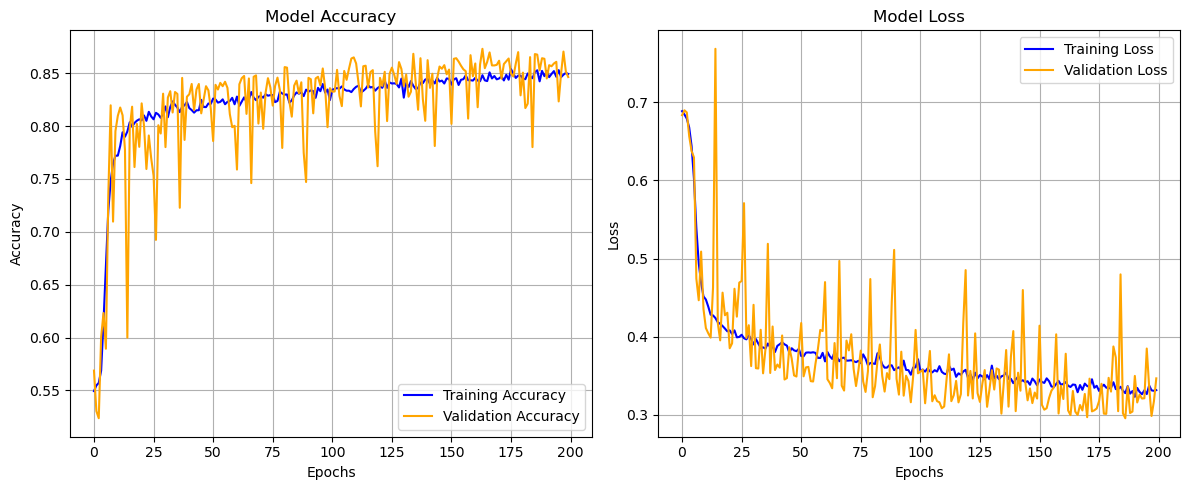

In [14]:
plot_training_history(history_lstm)

Evaluates LSTM Model for each stock.

Test results for stock: BBAS3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.81
Precision: 0.79
Recall: 0.73
F1 Score: 0.76
Confusion Matrix:


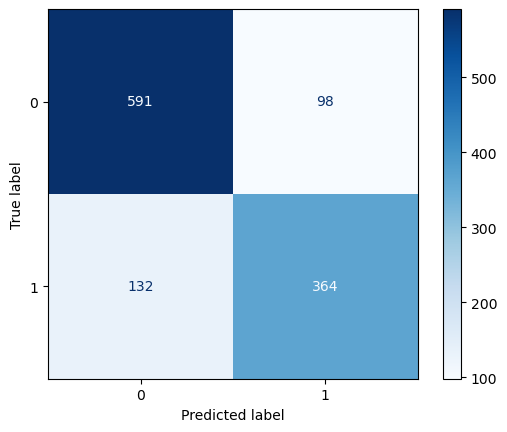


Test results for stock: CSNA3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
Accuracy: 0.87
Precision: 0.82
Recall: 0.88
F1 Score: 0.85
Confusion Matrix:


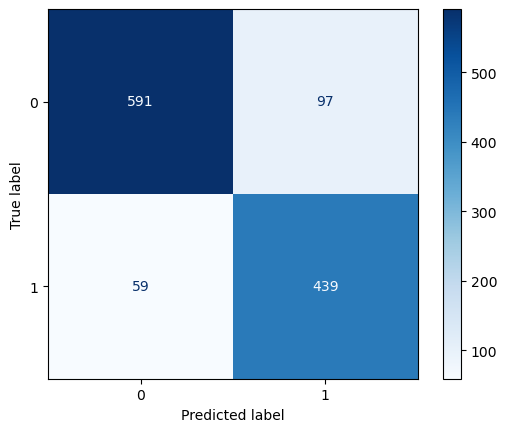


Test results for stock: PETR4.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
Accuracy: 0.82
Precision: 0.86
Recall: 0.78
F1 Score: 0.82
Confusion Matrix:


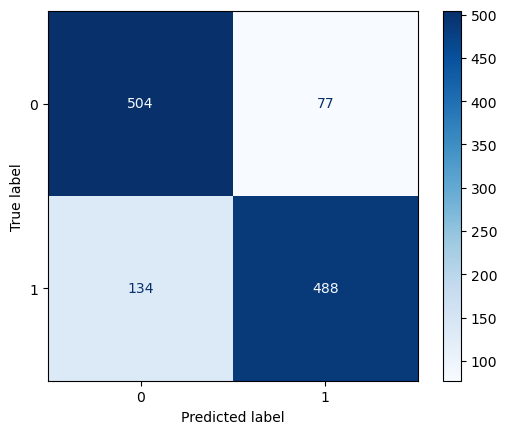


Test results for stock: VALE3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
Accuracy: 0.61
Precision: 0.78
Recall: 0.31
F1 Score: 0.45
Confusion Matrix:


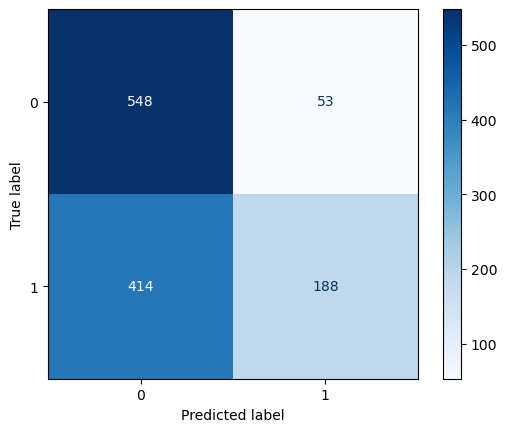

In [15]:
# Evaluate LSTM model on test data for each stock
for stock_name, stock_test_df in zip(stocks, test_dfs):
    X_test = stock_test_df.iloc[:, 4:].values
    X_test = scaler.transform(X_test)
    y_test = stock_test_df.iloc[:, 3].values

    print(f"Test results for stock: {stock_name}")
    
    # Make predictions using the LSTM model
    y_pred_probs = model_lstm.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the computed metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Confusion Matrix:")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print()


### CNN1d  Model.

In [ ]:
# Define the model
model_cnn = Sequential([
    Input(shape=(15, 1)),                                   # Explicit Input layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),   # 1D Convolutional layer
    MaxPooling1D(pool_size=2),                              # MaxPooling layer to reduce dimensionality
    Conv1D(filters=32, kernel_size=5, activation='relu'),   # Another Conv1D layer
    Flatten(),                                              # Flatten layer to transition from CNN to Dense
    Dense(64, activation='relu'),                           # Fully connected dense layer
    Dropout(0.3),                                           # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')                          # Output layer for binary classification
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model_cnn.summary()

cnn_checkpoint = save_best_model(f"cnn_{model_cnn.name}", save_dir_cnn)

# Fit the model
history_cnn = model_cnn.fit(
    train_features, labels,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[early_stopping, cnn_checkpoint]  
)

save_last_model(model_cnn, "cnn", save_dir_cnn)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 11, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 32)          │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,833 (50.13 KB)

 Trainable params: 12,833 (50.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


I0000 00:00:1739993418.272217  905049 service.cc:146] XLA service 0x74337978f880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739993418.272237  905049 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-19 16:30:18.284850: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


309/478 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.5520 - loss: 0.6924

I0000 00:00:1739993419.298598  905049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5675 - loss: 0.6806  
Epoch 1: val_loss improved from inf to 0.39432, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_sequential_2.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5676 - loss: 0.6805 - val_accuracy: 0.8282 - val_loss: 0.3943
Epoch 2/200
393/478 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.7544 - loss: 0.5093
Epoch 2: val_loss did not improve from 0.39432
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7575 - loss: 0.5059 - val_accuracy: 0.7931 - val_loss: 0.5271
Epoch 3/200
406/478 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8070 - loss: 0.4388
Epoch 3: val_loss improved from 0.39432 to 0.37382, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_sequential_2.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.8084 - loss: 0.4365 - val_accuracy: 0.8510 - val_loss: 0.3738
Epoch 4/200
394/4

Plotting CNN1d Model's training history.

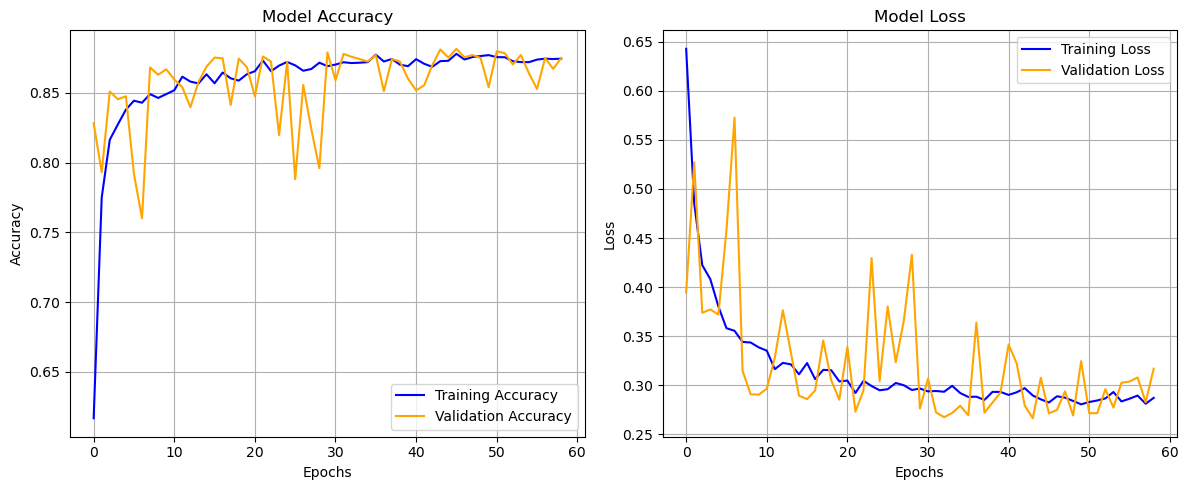

In [23]:
plot_training_history(history_cnn)

Evaluates CNN1d Model for each stock.

Test results for stock: BBAS3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
sequential_2
Accuracy: 0.88
Precision: 0.82
Recall: 0.92
F1 Score: 0.87
Confusion Matrix:


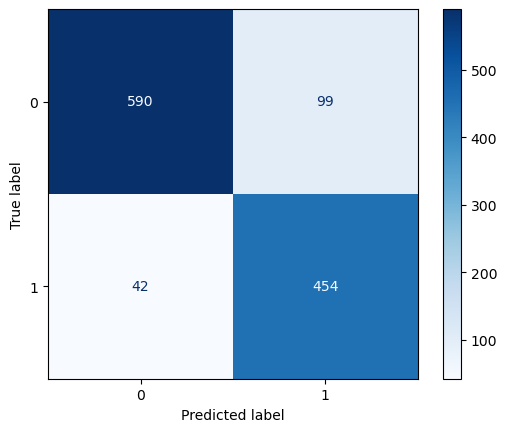


Test results for stock: CSNA3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
sequential_2
Accuracy: 0.89
Precision: 0.86
Recall: 0.90
F1 Score: 0.88
Confusion Matrix:


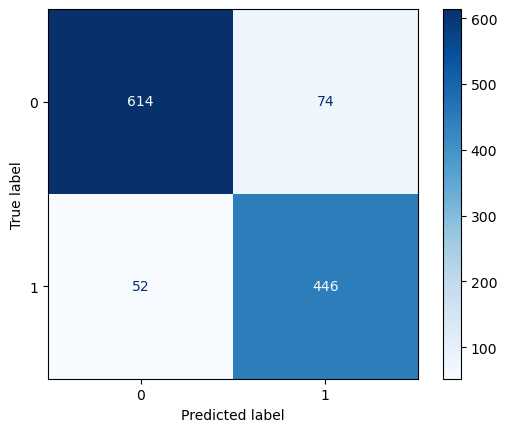


Test results for stock: PETR4.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
sequential_2
Accuracy: 0.86
Precision: 0.88
Recall: 0.83
F1 Score: 0.86
Confusion Matrix:


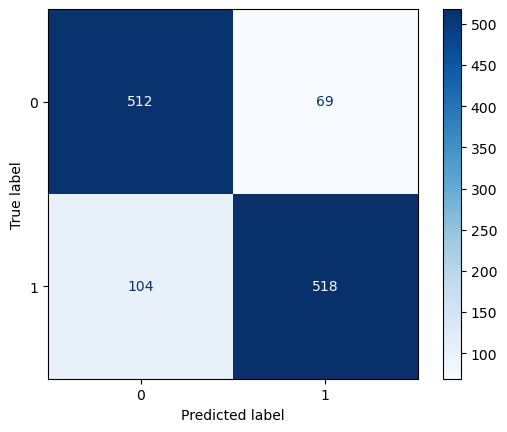


Test results for stock: VALE3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
sequential_2
Accuracy: 0.89
Precision: 0.84
Recall: 0.96
F1 Score: 0.89
Confusion Matrix:


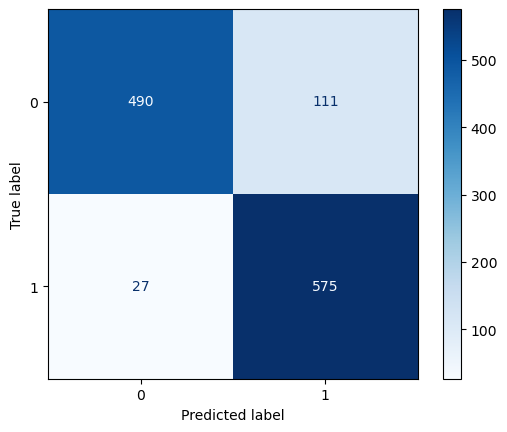

In [24]:
for stock_name, stock_test_df in zip(stocks, test_dfs):
    X_test = stock_test_df.iloc[:, 4:].values
    y_test = stock_test_df.iloc[:, 3].values

    print(f"Test results for stock: {stock_name}")
    y_pred_probs = model_cnn.predict(X_test)
    print(model_cnn.name)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Confusion Matrix:")
    # print(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)  # Set colormap here
    plt.show()
    print()